# Notebook to get rough estimate of cluster job sizing

In [1]:
import xarray as xr
import numpy as np
import time as tm
import os
import gc
import pickle
import matplotlib.pyplot as plt
from scipy.stats import linregress
import random
from tqdm.notebook import tqdm #tqdm is progress bar
import ipywidgets as widgets

### Quick Notes on Memory Usage

- For a dump size of $250$ memory doesn't seem to peak to more than 1GB.
- CPU usage is only about 1

## Timings Estimates

Bottle neck is in step 5, which is controlled by $k_b$.

Reccomendation is to split job in to three parts:

- part1 : $k_a = 5000$, $k_b = 4000$ ~ $60$ hours
- part2 : $k_b = 4000$ ~ $50$ hours
- part3 : $k_b = 4000$, $k_c = 5000$ ~ $60$ hours

### $k_a$ effect

In [2]:
# Fetching Timings
directory = 'ka-timings'
step1_timings = []
ka_values = []
for subdir in os.listdir(directory):
    where = f'{directory}/{subdir}'
    timings = pickle.load(open(f"{where}/timings.p", 'rb'))
    step1_timings.append(timings['Step1'])
    
    for data in os.listdir(f'{where}/step5'):
        ds = xr.open_dataset(f'{where}/step5/{data}')
        ka_values.append(ds.attrs['ka'])
        ds.close()
ka_timings = np.array(list(zip(ka_values, step1_timings)))

In [3]:
# Quick Linear Regression
ka_line = linregress(ka_timings[:, 0], ka_timings[:, 1])

def ka_timer(ka):
    """how many hours for certain number of ka"""
    slope = ka_line[0]
    intercept = ka_line[1]
    return (slope * ka + intercept)/3600

Text(0.5, 1.0, 'Timing ka')

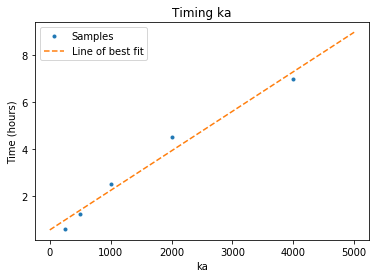

In [4]:
plt.plot(ka_timings[:, 0], ka_timings[:, 1]/3600, '.', label = 'Samples')
x_values = np.linspace(0, 5000, 100)
plt.plot(x_values, [ka_timer(x) for x in x_values], '--', label ='Line of best fit')
plt.xlabel('ka')
plt.ylabel('Time (hours)')
plt.legend()
plt.title('Timing ka')

In [5]:
ka_timer(5000)

8.966799278353543

### $k_b$ effect

In [6]:
# Fetching Slowed Timings

def fetch_kb_timings(directory):
    step25_timings = []
    kb_values = []
    step2_timings = []
    step5_timings = []
    for subdir in os.listdir(directory):
        where = f'{directory}/{subdir}'
        timings = pickle.load(open(f"{where}/timings.p", 'rb'))
        step2_timings.append(timings['Step2'])
        step5_timings.append(timings['Step5'])
        step25_timings.append(timings['Step2'] + timings['Step5']) 
        data = os.listdir(f'{where}/step5')[0] # only need kb from one place
        ds = xr.open_dataset(f'{where}/step5/{data}')
        kb_values.append(ds.attrs['kb'])
        ds.close()
    kb_timings = np.array(list(zip(kb_values, step25_timings))) # combined
    step5_timings = np.array(list(zip(kb_values, step5_timings)))
    step2_timings = np.array(list(zip(kb_values, step2_timings)))
    return kb_timings, step5_timings, step2_timings

kb_timings, step5_timings, step2_timings = fetch_kb_timings('kb-timings')
kb_faster, step5_faster, step2_faster = fetch_kb_timings('kb-faster')

### Overall time effect of $k_b$

In [7]:
# Quick Linear Regression
kb_line = linregress(kb_timings[:, 0], kb_timings[:, 1])

def kb_timer(kb):
    """how many hours for certain number of kb"""
    slope = kb_line[0]
    intercept = kb_line[1]
    return (slope * kb + intercept)/3600

### Time effect of $k_b$ on step $2$

In [8]:
# Quick Linear Regression
step2_line = linregress(step2_timings[:, 0], step2_timings[:, 1])

def step2_timer(kb):
    """how many hours for certain number of kb"""
    slope = step2_line[0]
    intercept = step2_line[1]
    return (slope * kb + intercept)/3600

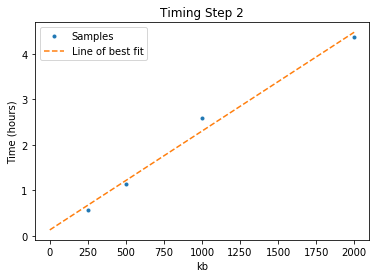

In [9]:
plt.plot(step2_timings[:, 0], step2_timings[:, 1]/3600, '.', label = 'Samples')
x_values = np.linspace(0, 2000, 100)
plt.plot(x_values, [step2_timer(x) for x in x_values], '--', label ='Line of best fit')
plt.xlabel('kb')
plt.ylabel('Time (hours)')
plt.title('Timing Step 2')
plt.legend()
plt.show()

In [10]:
step2_timer(15000)

32.711177479748564

### Time effect of $k_b$ on step $5$

In [11]:
# Quick Linear Regression
step5_line = linregress(step5_timings[:, 0], step5_timings[:, 1])

def step5_timer(kb):
    """how many hours for certain number of kb"""
    slope = step5_line[0]
    intercept = step5_line[1]
    return (slope * kb + intercept)/3600

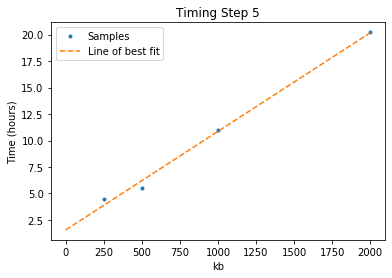

In [12]:
plt.plot(step5_timings[:, 0], step5_timings[:, 1]/3600, '.', label = 'Samples')
x_values = np.linspace(0, 2000, 100)
plt.plot(x_values, [step5_timer(x) for x in x_values], '--', label ='Line of best fit')
plt.xlabel('kb')
plt.ylabel('Time (hours)')
plt.title('Timing Step 5')
plt.legend()
plt.show()

In [13]:
step5_timer(12)

1.673180189026795

### Overall time effect of $k_b$

In [14]:
# Quick Linear Regression
kb_line = linregress(kb_timings[:, 0], kb_timings[:, 1])

def kb_timer(kb):
    """how many hours for certain number of kb"""
    slope = kb_line[0]
    intercept = kb_line[1]
    return (slope * kb + intercept)/3600

In [15]:
kb_timer(5000)

59.056279682626474

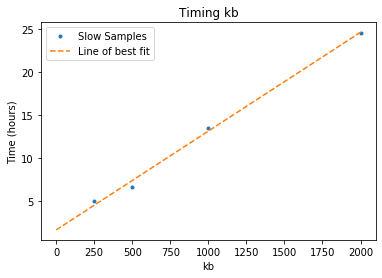

In [16]:
plt.plot(kb_timings[:, 0], kb_timings[:, 1]/3600, '.', label = 'Slow Samples')
x_values = np.linspace(0, 2000, 100)
plt.plot(x_values, [kb_timer(x) for x in x_values], '--', label ='Line of best fit')
plt.xlabel('kb')
plt.ylabel('Time (hours)')
plt.title('Timing kb')
plt.legend()
plt.show()

# Faster $k_b$

In [17]:
fastkb_line = linregress(kb_faster[:, 0], kb_faster[:, 1])
def fast_kb_timer(kb):
    """how many hours for certain number of kb"""
    slope = fastkb_line[0]
    intercept = fastkb_line[1]
    return (slope * kb + intercept)/3600

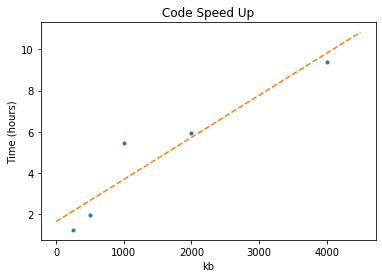

In [18]:
#plt.plot(kb_timings[:, 0], kb_timings[:, 1]/3600, '.', label = 'Slow Samples')
x_values = np.linspace(0, 4500, 100)
#plt.plot(x_values, [kb_timer(x) for x in x_values], '--', label ='Line of best fit')
plt.plot(kb_faster[:, 0], kb_faster[:, 1]/3600, '.', label = 'Fast Samples')
plt.plot(x_values, [fast_kb_timer(x) for x in x_values], '--', label ='Fast Line of best fit')
plt.xlabel('kb')
plt.ylabel('Time (hours)')
plt.title('Code Speed Up')
plt.show()

### $k_c$ effect

In [19]:
# Fetching Timings
directory = 'kc-timings'
step34_timings = []
kc_values = []
for subdir in os.listdir(directory):
    where = f'{directory}/{subdir}'
    timings = pickle.load(open(f"{where}/timings.p", 'rb'))
    step34_timings.append(timings['Step3'] + timings['Step4'])
    data = os.listdir(f'{where}/step5')[0] # only need kb from one place
    ds = xr.open_dataset(f'{where}/step5/{data}')
    kc_values.append(ds.attrs['kc'])
    ds.close()
kc_timings = np.array(list(zip(kc_values, step34_timings)))

In [20]:
# Quick Linear Regression
kc_line = linregress(kc_timings[:, 0], kc_timings[:, 1])

def kc_timer(kc):
    """how many hours for certain number of ka"""
    slope = kc_line[0]
    intercept = kc_line[1]
    return (slope * kc + intercept)/3600

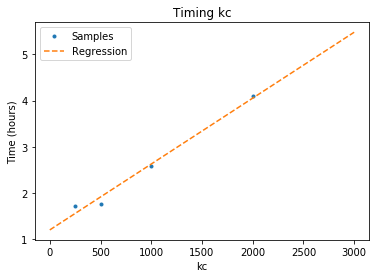

In [21]:
plt.plot(kc_timings[:, 0], kc_timings[:, 1]/3600, '.', label = 'Samples')
x_values = np.linspace(0, 3000, 100)
plt.plot(x_values, [kc_timer(x) for x in x_values], '--', label='Regression')
plt.xlabel('kc')
plt.ylabel('Time (hours)')
plt.title('Timing kc')
plt.legend()
plt.show()

### Estimate on how to split job up

In [22]:
ka_timer(5000) + kb_timer(4500) 

62.2862506158471

In [23]:
kb_timer(10000)/5

23.284912626791115

In [24]:
kb_timer(1000) + kc_timer(5000) 

21.48829750324908

In [29]:
ka_timer(5000) + fast_kb_timer(25000)  + kc_timer(5000)

70.07094165502025

### Timing Step 5

Seems slowdown is from dumping and/or observations call in Lyapunov Looker

In [26]:
from ginelli_observers import *
import ginelli_utilities as utilities
import l96tangent as l96t

In [27]:
runner = l96t.Integrator()
tau= 0.1
ginelli_runner = utilities.Forward(runner, tau)
parameters = ginelli_runner.parameter_dict.copy()